# SCvx CubeSat (scaled variables, CVXpy-ECOS)

In [ ]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import time
import ecos
import math
from scipy.spatial.transform import Rotation as R, Slerp
import plotly.graph_objs as go

print("numpy version",np.__version__)
print("cvxpy version",cp.__version__)

T = 31-1 # 101-1 means 101 discretization points
tf = 200.0
tau = tf/(T)
size_N=20
print("Step: ",tau," [s]")

start_quat=np.array([[0],[1],[0],[0]])
#end_quat=np.array([[0.3**0.5],[0.4**0.5],[0.1**0.5],[0.2**0.5]])
end_quat=np.array([[0],[0],[0],[1]])

#r = R.from_euler('xyz', [45*np.pi/180, 25*np.pi/180, 115*np.pi/180])
#end_quat=np.reshape(np.array(r.as_quat()),(4,1))

print(end_quat)

startpos=np.block([[start_quat],[0],[0],[0]])
endpos=np.block([[end_quat],[0],[0],[0]])

J1_double=0.0333
J2_double=0.0333
J3_double=0.0067

u_max_torq_double = 0.001 #Aspina RW

omega_max_double = 10.0*np.pi/180 #deg/s

#Guidance parameters
rho0=0.0
rho1=0.1
rho2=0.7
etta0=0.001
etta1=5
beta_sh=2
beta_gr=2

lamb_double=2000
etta_double=0.1

e_tol=0.05
epsilon_stop_norm=0.04

u_qw_scaling=np.array([[1/(1*u_max_torq_double),0,0],[0,1/(1*u_max_torq_double),0],[0,0,1/(1*u_max_torq_double)]])

numpy version 2.2.5
cvxpy version 1.7.5
Step:  6.666666666666667  [s]
[[0]
 [0]
 [0]
 [1]]


In [44]:
nx = cp.Variable((7, T + 1), name='nx')
u = cp.Variable((3, T), name='u')
vc = cp.Variable((7, T), name='vc')

startpos_cvxpy = cp.Parameter((7,1), name='start_pos')
endpos_cvxpy = cp.Parameter((7,1), name='end_pos')

ox_cvxpy = cp.Parameter((7,T + 1), name='ox_cvxpy')
ou_cvxpy = cp.Parameter((3,T), name='ou_cvxpy')

A_discrete_qw = cp.Parameter((7,7*T), name='A_discrete_qw')
B_discrete_qw_scaled = cp.Parameter((7,3*T), name='B_discrete_qw_scaled')
w_discrete_qw = cp.Parameter((7,T), name='w_discrete_qw')

lamb = cp.Parameter(name='lamb')
etta = cp.Parameter(name='etta')

vel_max = cp.Parameter(name='vel_max')
omega_max = cp.Parameter(name='omega_max')

constraints = [
    nx[:, 0] == startpos_cvxpy[:,0],
    nx[:, T] == endpos_cvxpy[:,0],
    #u[:,0]==0,u[:,-1]==0
]
cost = 0

for k in range(0, T): # from 0 to T-1

    constraints += [nx[0:7, k+1] == A_discrete_qw[:,7*k:7*k+7] @ nx[0:7, k] + B_discrete_qw_scaled[:,3*k:3*k+3] @ (u[0:3, k]) + w_discrete_qw[:,k] + vc[0:7, k]] #q1_k+1
    
    constraints += [cp.norm(u[0:3, k], 2) <= 1]

    cost += tau*cp.sum_squares(u[0:3,k])
    cost += tau*cp.norm(lamb*vc[:, k], 1)
    constraints  += [cp.norm(nx[:, k]-ox_cvxpy[:,k],'inf')+cp.norm(u[:, k]-ou_cvxpy[:,k],'inf')<=etta]

for k in range(0, T+1):
    constraints += [cp.norm(nx[4:7,k], 2)<=omega_max]

objective = cp.Minimize(cost)
problem = cp.Problem(objective, constraints)

In [45]:
print("Is DPP? ", problem.is_dcp(dpp=True))

Is DPP?  True


In [46]:
aux_A_discrete_qw = np.zeros((7,7*T))
aux_B_discrete_qw_scaled = np.zeros((7,3*T))
aux_w_discrete_qw = np.zeros((7,T))

In [47]:
def scaling_begin(u,u_scaling,T):
    for k in range(0, T):
        u[:,k:k+1]=u_scaling@u[:,k:k+1]
    return u
def scaling_end(u,u_scaling,T):
    for k in range(0, T):
        u[:,k:k+1]=np.linalg.inv(u_scaling)@u[:,k:k+1]
    return u
    
def slerp(q1, q2, num_samples):
    dot = np.dot(q1, q2)
    if dot < 0.0:
        q2 = -q2
        dot = -dot
    dot = np.clip(dot, -1.0, 1.0)
    theta_0 = np.arccos(dot)

    if np.abs(theta_0) < 1e-6:
        return np.linspace(q1, q2, num_samples)

    sin_theta_0 = np.sin(theta_0)

    quaternions = []
    for i in range(num_samples):
        t = i / (num_samples - 1)
        theta = theta_0 * t
        sin_theta = np.sin(theta)
        s0 = np.cos(theta) - dot * sin_theta / sin_theta_0
        s1 = sin_theta / sin_theta_0
        quaternions.append(s0 * q1 + s1 * q2)

    return np.array(quaternions)

def compute_angular_velocity(quaternions, dt):

    rotations = R.from_quat(quaternions)
    angular_velocities = [[0,0,0]]

    for i in range(len(rotations) - 1):
        delta_rot = rotations[i + 1] * rotations[i].inv()
        log_rot = delta_rot.as_rotvec() / dt
        angular_velocities.append(log_rot)

    return np.array(angular_velocities)

def exp_matrix_taylor_A(A,h,n):
    size_n,size_aux=np.shape(A)
    sum=np.eye(size_n)+A*h
    for i in range(2,n+2,1):
        sum=sum+1/math.factorial(i)*np.linalg.matrix_power(h*A,i)
    return sum

def exp_matrix_taylor_B(A,B,h,n):
    size_n,size_aux=np.shape(A)
    sum=h*np.eye(size_n)
    for i in range(2,n+2,1):
        sum=sum+1/math.factorial(i)*np.linalg.matrix_power(A,i-1)*h**i
    return sum@B

def f_qw(x,u):
    aux_f=np.zeros((7,1))

    oq1=x[0,0]
    oq2=x[1,0]
    oq3=x[2,0]
    oq4=x[3,0]
    ow1=x[4,0]
    ow2=x[5,0]
    ow3=x[6,0]

    ou1=u[0,0]
    ou2=u[1,0]
    ou3=u[2,0]

    aux_f[0,0]=0.5*(oq4*ow1-oq3*ow2+oq2*ow3)
    aux_f[1,0]=0.5*(oq3*ow1+oq4*ow2-oq1*ow3)
    aux_f[2,0]=0.5*(-oq2*ow1+oq1*ow2+oq4*ow3)
    aux_f[3,0]=0.5*(-oq1*ow1-oq2*ow2-oq3*ow3)

    aux_f[4,0]=(1/J1_double)*(-(J3_double-J2_double)*ow2*ow3+ou1)
    aux_f[5,0]=(1/J2_double)*(-(J1_double-J3_double)*ow3*ow1+ou2)
    aux_f[6,0]=(1/J3_double)*(-(J2_double-J1_double)*ow1*ow2+ou3)
    return aux_f

def A_qw(oxqw):
  oq1=oxqw[0,0]
  oq2=oxqw[1,0]
  oq3=oxqw[2,0]
  oq4=oxqw[3,0]
  ow1=oxqw[4,0]
  ow2=oxqw[5,0]
  ow3=oxqw[6,0]
  aux_A_qw=np.zeros((7,7))
  aux_A_qw[0:4,:]=0.5*np.array([[0,ow3,-ow2,ow1,oq4,-oq3,oq2],
                            [-ow3,0,ow1,ow2,oq3,oq4,-oq1],
                            [ow2,-ow1,0,ow3,-oq2,oq1,oq4],
                            [-ow1,-ow2,-ow3,0,-oq1,-oq2,-oq3]])
  aux_A_qw[4:7,:] = np.array([
                     [0,0,0,0,0,1/J1_double*(-(J3_double-J2_double)*ow3),1/J1_double*(-(J3_double-J2_double)*ow2)],
                     [0,0,0,0,1/J2_double*(-(J1_double-J3_double)*ow3),0,1/J2_double*(-(J1_double-J3_double)*ow1)],
                     [0,0,0,0,1/J3_double*(-(J2_double-J1_double)*ow2),1/J3_double*(-(J2_double-J1_double)*ow1),0]])
  return aux_A_qw
def B_qw(oxqw):
  aux_B_qw = np.block([[np.zeros((4,3))],[1/J1_double,0,0],[0,1/J2_double,0],[0,0,1/J3_double]])
  return aux_B_qw
def w_qw(oxqw,ou):
  aux_w_qw=f_qw(oxqw,ou)-A_qw(oxqw)@oxqw
  return aux_w_qw

ox_quat = slerp(startpos[0:4,0], endpos[0:4,0],T+1).T
ox_angvel = compute_angular_velocity(ox_quat.T, tau).T

ox=np.zeros((7,T+1))
ox[0:4,:]=ox_quat
ox[4:7,:]=ox_angvel

ou=np.zeros((3,T))

omega_max.value=omega_max_double

In [48]:
def f_qw_rk4_step(xk, uk, dt):
    k1 = f_qw(xk, uk)
    k2 = f_qw(xk + 0.5 * dt * k1, uk)
    k3 = f_qw(xk + 0.5 * dt * k2, uk)
    k4 = f_qw(xk + dt * k3, uk)
    return xk + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

def f_qw_rk5_step(xk, uk, dt):
    k1 = f_qw(xk, uk)
    k2 = f_qw(xk + (1/4) * dt * k1, uk)
    k3 = f_qw(xk + (3/8) * dt * k2, uk)
    k4 = f_qw(xk + (12/13) * dt * k3, uk)
    k5 = f_qw(xk + dt * k4, uk)
    k6 = f_qw(xk + (1/2) * dt * k5, uk)
    
    return xk + dt * (16/135 * k1 + 6656/12825 * k3 + 28561/56430 * k4 - 9/50 * k5 + 2/55 * k6)

def f_qw_Euler(xk, uk, dt):
    return xk + dt * f_qw(xk, uk)

def f_SCVx(xk,uk):
    xk1=np.zeros((7,1))
    xk_aux=np.copy(xk[0:7,0:1])
    for N in range(0,size_N,1):
        xk_aux=f_qw_rk5_step(xk_aux, uk[0:3,0:1], tau/size_N)
    
    xk1[0:7,0:1]=np.copy(xk_aux)

    return xk1

def J_SCVx(x,u,T):
    cost = 0
    for k in range(0, T): # from 0 to T-1
        cost += tau*np.linalg.norm(u[0:3,k], ord=2)**2
    print("Cost 1: ",cost)
    u[0:3,:] = scaling_end(u[0:3,:],u_qw_scaling,T) #scaling end

    for k in range(0, T): # from 0 to T-1
        cost += tau*np.linalg.norm(lamb_double*(x[:, k+1:k+2]-f_SCVx(x[:, k:k+1],u[:, k:k+1])), ord=1)

    u[0:3,:]=scaling_begin(u[0:3,:],u_qw_scaling,T) #scaling begin
    print("Cost 2: ",cost)
    return cost

def L_SCVx(x,u,vc,T):
    cost = 0
    for k in range(0, T): # from 0 to T-1
        cost += tau*np.linalg.norm(u[0:3,k], ord=2)**2
        cost += tau*np.linalg.norm(lamb_double*(vc[:, k]), ord=1)

    return cost

startpos_cvxpy.value=startpos
endpos_cvxpy.value=endpos

t0 = time.time()

lamb.value = lamb_double
etta.value = etta_double

ou[0:3,:]=scaling_begin(ou[0:3,:],u_qw_scaling,T) #scaling begin

ox_cvxpy.value=np.copy(ox) #trajectory initialization (solver, scaled)
ou_cvxpy.value=np.copy(ou) #trajectory initialization (solver, scaled)

i=1
no_first_iterations = False
while True:

    ou[0:3,:] = scaling_end(ou[0:3,:],u_qw_scaling,T) #scaling end

    for k in range(0, T):
        aux_A_discrete_qw[0:7,7*k:7*k+7] = exp_matrix_taylor_A(A_qw(ox[0:7,k:k+1]),tau,7)
        #aux_matrix_Bqw=np.block([[B_qw(ox[6:13,k:k+1])[0:4,:]],[B_qw(ox[6:13,k:k+1])[4:7,:]@np.linalg.inv(u_qw_scaling)]])
        aux_B_discrete_qw_scaled[0:7,3*k:3*k+3] = exp_matrix_taylor_B(A_qw(ox[0:7,k:k+1]),B_qw(ox[0:7,k:k+1])@np.linalg.inv(u_qw_scaling),tau,7)
        aux_w_discrete_qw[0:7,k:k+1] = exp_matrix_taylor_B(A_qw(ox[0:7,k:k+1]),w_qw(ox[0:7,k:k+1],np.zeros((3,1))),tau,7)

    A_discrete_qw.value = np.copy(aux_A_discrete_qw)
    B_discrete_qw_scaled.value = np.copy(aux_B_discrete_qw_scaled)
    w_discrete_qw.value = np.copy(aux_w_discrete_qw)

    val=problem.solve(solver="ECOS",ignore_dpp=True) #IF YOU USE CVXPYGEN: ignore_dpp=False


    vc_opt=np.copy(vc.value)
    x_opt=np.copy(nx.value)
    u_opt=np.copy(u.value)

    ou[0:3,:]=scaling_begin(ou[0:3,:],u_qw_scaling,T) #scaling begin

    oJ_SCVx=J_SCVx(ox,ou,T)
    J_SCVx_opt=J_SCVx(x_opt,u_opt,T)
    L_SCVx_opt=L_SCVx(x_opt,u_opt,vc_opt,T)
    

    Delta_J_SCVx=oJ_SCVx-J_SCVx_opt
    Delta_L_SCVx=oJ_SCVx-L_SCVx_opt
    print("oJ_SCVx: ",oJ_SCVx,"J_SCVx_opt",J_SCVx_opt,"L_SCVx_opt",L_SCVx_opt,"cvxpy_L",val,"Norm_x_diff: ",np.max(np.linalg.norm((x_opt-ox), ord=2,axis=0)))
    
    if (Delta_L_SCVx<e_tol*np.abs(oJ_SCVx) or np.max(np.linalg.norm((x_opt-ox), ord=1,axis=0))<epsilon_stop_norm) and no_first_iterations:
      
      ou[0:3,:] = scaling_end(ou[0:3,:],u_qw_scaling,T) #scaling end

      x_global=np.copy(ox)
      u_global=np.copy(ou)
      break;
    
    else:
      rho_i=Delta_J_SCVx/Delta_L_SCVx
      if rho_i<rho0:
        etta.value=max([etta0,etta.value/beta_sh])
        ox=np.copy(ox)
        ou=np.copy(ou)
      if rho_i>=rho0 and rho_i<rho1:
        etta.value=max([etta0,etta.value/beta_sh])
        ox=np.copy(x_opt)
        ou=np.copy(u_opt)
      if rho_i>=rho1 and rho_i<rho2:
        ox=np.copy(x_opt)
        ou=np.copy(u_opt)
      if rho_i>=rho2:
        etta.value=min([etta1,beta_gr*etta.value])
        ox=np.copy(x_opt)
        ou=np.copy(u_opt)

      print(" Iteration number: ",i," Cost function: ", val," Etta: ",etta.value, " Rho: ",rho_i)

    ox_cvxpy.value=np.copy(ox)
    ou_cvxpy.value=np.copy(ou)

    if i==3:
        no_first_iterations = True
    i=i+1
    
t1 = time.time()
print('\nCVXPY\nSolve time: %.3f ms' % (1000 * (t1 - t0)))

Cost 1:  0.0
Cost 2:  925.5412635886397
Cost 1:  1.240246758316148
Cost 2:  424.00302217909825
oJ_SCVx:  925.5412635886397 J_SCVx_opt 424.00302217909825 L_SCVx_opt 403.16804827649855 cvxpy_L 403.16804827649855 Norm_x_diff:  0.05202035359720045
 Iteration number:  1  Cost function:  403.16804827649855  Etta:  0.2  Rho:  0.9601147737060947
Cost 1:  1.2402467583161476
Cost 2:  424.00302217909825
Cost 1:  12.058875970234984
Cost 2:  392.36921108415754
oJ_SCVx:  424.00302217909825 J_SCVx_opt 392.36921108415754 L_SCVx_opt 339.31078857135384 cvxpy_L 339.31078857135384 Norm_x_diff:  0.03148038304865776
 Iteration number:  2  Cost function:  339.31078857135384  Etta:  0.2  Rho:  0.3735148991518398
Cost 1:  12.058875970234979
Cost 2:  392.36921108415754
Cost 1:  32.252393352721846
Cost 2:  338.7728959453345
oJ_SCVx:  392.36921108415754 J_SCVx_opt 338.7728959453345 L_SCVx_opt 286.6176086087878 cvxpy_L 286.6176086087878 Norm_x_diff:  0.029010741786971952
 Iteration number:  3  Cost function:  286.

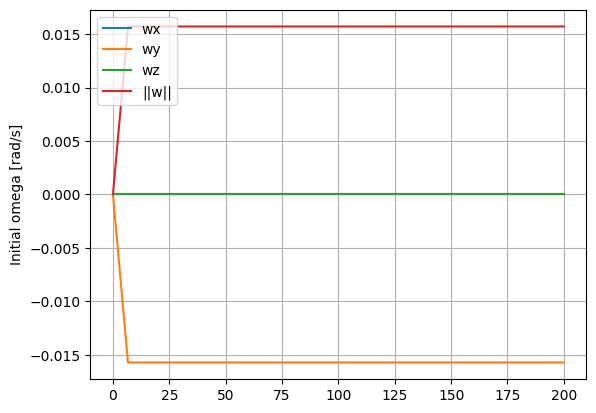

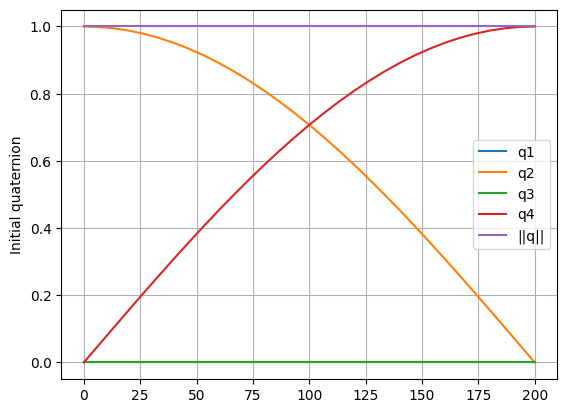

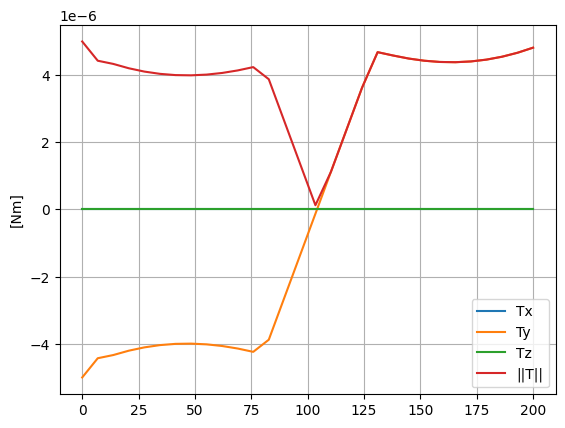

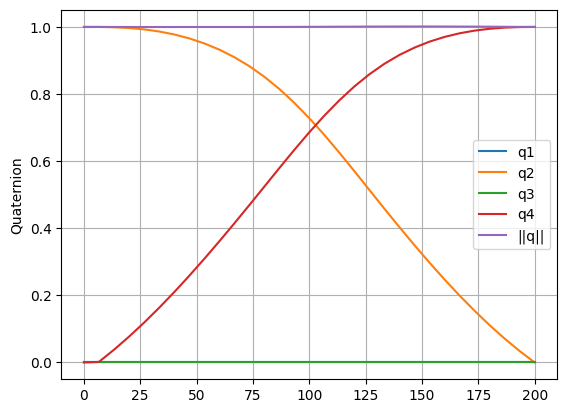

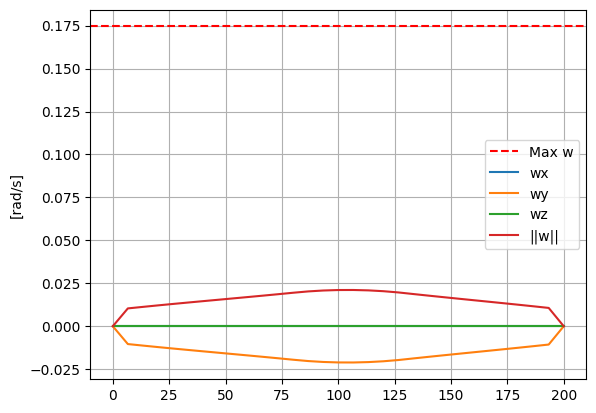

In [49]:
u_value=np.copy(u_global)
nx_value=np.copy(x_global)
#u_value = scaling_begin(u_value,u_qw_scaling,T)
#print(u_value)

plt.figure(2)
plt.plot(np.linspace(0, tf, T+1), ox_angvel[0,:], label='wx')
plt.plot(np.linspace(0, tf, T+1), ox_angvel[1,:], label='wy')
plt.plot(np.linspace(0, tf, T+1), ox_angvel[2,:], label='wz')
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(ox_angvel,axis=0), label='||w||')
plt.ylabel('Initial omega [rad/s]')
plt.gca().tick_params(labelsize=10)
plt.legend()
plt.grid(True)

plt.figure(3)
plt.plot(np.linspace(0, tf, T+1), ox_quat[0,:], label='q1')
plt.plot(np.linspace(0, tf, T+1), ox_quat[1,:], label='q2')
plt.plot(np.linspace(0, tf, T+1), ox_quat[2,:], label='q3')
plt.plot(np.linspace(0, tf, T+1), ox_quat[3,:], label='q4')
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(ox_quat,axis=0), label='||q||')
plt.ylabel('Initial quaternion')
plt.gca().tick_params(labelsize=10)
plt.legend()
plt.grid(True)

plt.figure(5)
#plt.axhline(y=u_max_torq_double, color='r', linestyle='--', label='Max T')
plt.plot(np.linspace(0, tf, T), u_value[0,:], label='Tx')
plt.plot(np.linspace(0, tf, T), u_value[1,:], label='Ty')
plt.plot(np.linspace(0, tf, T), u_value[2,:], label='Tz')
plt.plot(np.linspace(0, tf, T), np.linalg.norm(u_value[0:3,:],axis=0), label='||T||')
plt.ylabel('[Nm]')
plt.gca().tick_params(labelsize=10)
plt.legend()
plt.grid(True)

plt.figure(6)
plt.plot(np.linspace(0, tf, T+1), nx_value[0,:], label='q1')
plt.plot(np.linspace(0, tf, T+1), nx_value[1,:], label='q2')
plt.plot(np.linspace(0, tf, T+1), nx_value[2,:], label='q3')
plt.plot(np.linspace(0, tf, T+1), nx_value[3,:], label='q4')
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(nx_value[0:4,:],axis=0), label='||q||')
plt.ylabel('Quaternion')
plt.gca().tick_params(labelsize=10)
plt.legend()
plt.grid(True)

plt.figure(7)
plt.axhline(y=omega_max_double, color='r', linestyle='--', label='Max w')
plt.plot(np.linspace(0, tf, T+1), nx_value[4,:], label='wx')
plt.plot(np.linspace(0, tf, T+1), nx_value[5,:], label='wy')
plt.plot(np.linspace(0, tf, T+1), nx_value[6,:], label='wz')
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(nx_value[4:7,:],axis=0), label='||w||')
plt.ylabel('[rad/s]')
plt.gca().tick_params(labelsize=10)
plt.legend()
plt.grid(True)

In [50]:
print(np.linalg.norm(vc.value,2))

0.009770759528541515


In [8]:
def create_cube(size, quaternion):
    """Creates a rotated cube using a quaternion."""
    half = size / 2.0
    vertices = np.array([  # Cube vertices
        [-half, -half, -half-size], [half, -half, -half-size], [half, half, -half-size], [-half, half, -half-size],
        [-half, -half, half+size], [half, -half, half+size], [half, half, half+size], [-half, half, half+size]
    ])
 
    # Apply rotation using quaternion
    r = R.from_quat(quaternion)
    rotated_vertices = r.apply(vertices)

    # Cube faces (each face as a set of 4 vertices)
    faces = [
        [0, 1, 2, 3], [4, 5, 6, 7], [0, 1, 5, 4],
        [2, 3, 7, 6], [0, 3, 7, 4], [1, 2, 6, 5]
    ]

    # Define mesh faces for the cube
    i_faces = [face[0] for face in faces]
    j_faces = [face[1] for face in faces]
    k_faces = [face[2] for face in faces]
    i_faces += [face[0] for face in faces]
    j_faces += [face[2] for face in faces]
    k_faces += [face[3] for face in faces]

    # Mesh3d for the cube (white cube)
    cube = go.Mesh3d(
        x=rotated_vertices[:, 0], y=rotated_vertices[:, 1], z=rotated_vertices[:, 2],
        i=i_faces, j=j_faces, k=k_faces, opacity=1.0, color='white'
    )

    # Create "eyes" (small blue circles) on the cube's faces
    eye_radius = 0.1*0.2
    eye_positions = [
        [half,0.13*0.2,0], [half,-0.13*0.2,0]
    ]

    # Apply rotation to eye positions
    rotated_eye_positions = r.apply(eye_positions)

    eye_spheres = []
    for pos in rotated_eye_positions:
        u, v = np.mgrid[0:2*np.pi:10j, 0:np.pi:5j]
        x_eye = eye_radius * np.cos(u) * np.sin(v) + pos[0]
        y_eye = eye_radius * np.sin(u) * np.sin(v) + pos[1]
        z_eye = eye_radius * np.cos(v) + pos[2]
        
        # Crear una matriz de color uniforme (por ejemplo, azul con un solo valor)
        color_value = np.full_like(x_eye, 0.5)  # 0.5 es un tono de azul en la escala

        eye_spheres.append(go.Surface(
            x=x_eye, y=y_eye, z=z_eye, surfacecolor=color_value, 
            colorscale=[[0, 'deepskyblue'], [1, 'deepskyblue']], opacity=1.0, showscale=False
        ))

    return cube, eye_spheres

def create_spheres(spheres):
    """Creates spheres as surfaces."""
    sphere_traces = []
    for sphere in spheres:
        h, rc = sphere['h'], sphere['rc']
        u, v = np.mgrid[0:2*np.pi:16j, 0:np.pi:8j]
        x_sphere = rc * np.cos(u) * np.sin(v) + h[0]
        y_sphere = rc * np.sin(u) * np.sin(v) + h[1]
        z_sphere = rc * np.cos(v) + h[2]
        sphere_traces.append(go.Surface(
            x=x_sphere, y=y_sphere, z=z_sphere, colorscale='Reds', opacity=0.3, showscale=False
        ))
    return sphere_traces

def plot_3d_trajectory_with_cube(nx_value):
    quaternions = nx_value[0:4, :]

    # Set axis limits with uniform scaling
    padding = 0.5

    # Initial cube (white with blue eyes)
    cube, eye_spheres = create_cube(0.1, quaternions[:, 0])

    # Animation frames
    print(quaternions.shape[1])
    frames = [
        go.Frame(data=[
            create_cube(0.1, quaternions[:, k])[0],
        ] + create_cube(0.1, quaternions[:, k])[1])
        for k in range(quaternions.shape[1])
    ]

    layout = go.Layout(
        title='BIRDS-TM guidance',
        scene=dict(
            xaxis=dict(title='x [m]', range=[-0.4, 0.4]),
            yaxis=dict(title='y', range=[-0.4, 0.4]),
            zaxis=dict(title='z', range=[-0.4, 0.4]),

            aspectmode='cube',  # Ensures correct proportions
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))  # Adjust camera view for better visibility
        ),
        updatemenus=[dict(type='buttons', buttons=[dict(label='Play', method='animate',
                                                       args=[None, dict(frame=dict(duration=50, redraw=True),
                                                                        fromcurrent=True)])])])

    fig = go.Figure(data=[cube] + eye_spheres, layout=layout, frames=frames)
    fig.show()

plot_3d_trajectory_with_cube(nx_value)


31


In [ ]:
print("Quaternion norm vc: ",np.linalg.norm(vc.value[0:4,:], ord=1))
print("Angular velocity norm vc",np.linalg.norm(vc.value[4:7,:], ord=1))

Quaternion norm vc:  2.552313936234729e-10
Angular velocity norm vc 1.0665817497037922e-11


# SCVx Astrobee (scaled variables, CVXpygen-ECOS)

Run the following block just if you have already created a new solver.

In [10]:
from cvxpygen import cpg
cpg.generate_code(problem, code_dir='CUBESAT_SCVX_ECOS_T31',solver='ECOS')

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Generating code with CVXPYgen ...
CVXPYgen finished generating code.
Compiling python wrapper with CVXPYgen ... 
CVXPYgen finished compiling python wrapper.


c:\Users\franklin\anaconda3\envs\cvxpygen\lib\site-packages\setuptools\__init__.py:94: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)


-- Selecting Windows SDK version 10.0.26100.0 to target Windows 10.0.26200.
-- The C compiler identification is MSVC 19.44.35219.0
-- The CXX compiler identification is MSVC 19.44.35219.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: C:/Program Files/Microsoft Visual Studio/2022/Community/VC/Tools/MSVC/14.44.35207/bin/Hostx64/x64/cl.exe - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: C:/Program Files/Microsoft Visual Studio/2022/Community/VC/Tools/MSVC/14.44.35207/bin/Hostx64/x64/cl.exe - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Configuring done (2.9s)
-- Generating done (0.1s)
-- Build files have been written to: C:/Users/franklin/Documents/Kyutech/Thesis/Papers/Convex_FF/SCP_python/CubeSat_3U/CUBESAT_SCVX_ECOS_T31/c/build
MSBuild version 

In [11]:
from CUBESAT_SCVX_ECOS_T31.cpg_solver import cpg_solve #CHANGE
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt

with open('CUBESAT_SCVX_ECOS_T31/problem.pickle', 'rb') as file: #CHANGE
    problem = pickle.load(file)

problem.register_solve('cpg', cpg_solve)

In [12]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import time
import ecos
import math
from scipy.spatial.transform import Rotation as R

print("numpy version",np.__version__)
print("cvxpy version",cp.__version__)

T = 31-1 # 101-1 means 101 discretization points
tf = 500.0
tau = tf/(T)
size_N=20
print("Step: ",tau," [s]")

start_quat=np.array([[0],[1],[0],[0]])

#r = R.from_euler('xyz', [-45*np.pi/180, 55*np.pi/180, -150*np.pi/180])
#start_quat=-np.reshape(np.array(r.as_quat()),(4,1))

#end_quat=np.array([[0.3**0.5],[0.4**0.5],[0.1**0.5],[0.2**0.5]])
end_quat=np.array([[0],[0],[0],[1]])

#r = R.from_euler('xyz', [45*np.pi/180, 25*np.pi/180, 115*np.pi/180])
#end_quat=np.reshape(np.array(r.as_quat()),(4,1))

print(end_quat)
#end_quat=np.array([[1],[0],[0],[0]])

startpos=np.block([[start_quat],[0],[0],[0]])
endpos=np.block([[end_quat],[0],[0],[0]])

J1_double=0.0333
J2_double=0.0333
J3_double=0.0067

#u_max_torq_double = 100*0.0000002
u_max_torq_double = 0.001

omega_max_double = 1.0*np.pi/180

#Guidance parameters
rho0=0.0
rho1=0.1
rho2=0.7
etta0=0.001
etta1=10
beta_sh=2
beta_gr=2

lamb_double=1000
etta_double=10

e_tol=0.05
epsilon_stop_norm=0.04

u_qw_scaling=np.array([[1/u_max_torq_double,0,0],[0,1/u_max_torq_double,0],[0,0,1/u_max_torq_double]])

numpy version 2.2.6
cvxpy version 1.7.3
Step:  16.666666666666668  [s]
[[0]
 [0]
 [0]
 [1]]


In [13]:
aux_A_discrete_qw = np.zeros((7,7*T))
aux_B_discrete_qw_scaled = np.zeros((7,3*T))
aux_w_discrete_qw = np.zeros((7,T))

In [14]:
from scipy.spatial.transform import Rotation as R, Slerp

def scaling_begin(u,u_scaling,T):
    for k in range(0, T):
        u[:,k:k+1]=u_scaling@u[:,k:k+1]
    return u
def scaling_end(u,u_scaling,T):
    for k in range(0, T):
        u[:,k:k+1]=np.linalg.inv(u_scaling)@u[:,k:k+1]
    return u
    
def slerp(q1, q2, num_samples):
    dot = np.dot(q1, q2)
    if dot < 0.0:
        q2 = -q2
        dot = -dot
    dot = np.clip(dot, -1.0, 1.0)
    theta_0 = np.arccos(dot)

    if np.abs(theta_0) < 1e-6:
        return np.linspace(q1, q2, num_samples)

    sin_theta_0 = np.sin(theta_0)
    print("theta_0",theta_0)
    quaternions = []
    for i in range(num_samples):
        t = i / (num_samples - 1)
        theta = theta_0 * t
        sin_theta = np.sin(theta)
        s0 = np.cos(theta) - dot * sin_theta / sin_theta_0
        s1 = sin_theta / sin_theta_0
        quaternions.append(s0 * q1 + s1 * q2)

    return np.array(quaternions)

def compute_angular_velocity(quaternions, dt):

    rotations = R.from_quat(quaternions)
    angular_velocities = [[0,0,0]]

    for i in range(len(rotations) - 1):
        delta_rot = rotations[i + 1] * rotations[i].inv()
        log_rot = delta_rot.as_rotvec() / dt
        angular_velocities.append(log_rot)

    return np.array(angular_velocities)

def exp_matrix_taylor_A(A,h,n):
    size_n,size_aux=np.shape(A)
    sum=np.eye(size_n)+A*h
    for i in range(2,n+2,1):
        sum=sum+1/math.factorial(i)*np.linalg.matrix_power(h*A,i)
    return sum

def exp_matrix_taylor_B(A,B,h,n):
    size_n,size_aux=np.shape(A)
    sum=h*np.eye(size_n)
    for i in range(2,n+2,1):
        sum=sum+1/math.factorial(i)*np.linalg.matrix_power(A,i-1)*h**i
    return sum@B

def f_qw(x,u):
    aux_f=np.zeros((7,1))

    oq1=x[0,0]
    oq2=x[1,0]
    oq3=x[2,0]
    oq4=x[3,0]
    ow1=x[4,0]
    ow2=x[5,0]
    ow3=x[6,0]

    ou1=u[0,0]
    ou2=u[1,0]
    ou3=u[2,0]

    aux_f[0,0]=0.5*(oq4*ow1-oq3*ow2+oq2*ow3)
    aux_f[1,0]=0.5*(oq3*ow1+oq4*ow2-oq1*ow3)
    aux_f[2,0]=0.5*(-oq2*ow1+oq1*ow2+oq4*ow3)
    aux_f[3,0]=0.5*(-oq1*ow1-oq2*ow2-oq3*ow3)

    aux_f[4,0]=(1/J1_double)*(-(J3_double-J2_double)*ow2*ow3+ou1)
    aux_f[5,0]=(1/J2_double)*(-(J1_double-J3_double)*ow3*ow1+ou2)
    aux_f[6,0]=(1/J3_double)*(-(J2_double-J1_double)*ow1*ow2+ou3)
    return aux_f

def A_qw(oxqw):
  oq1=oxqw[0,0]
  oq2=oxqw[1,0]
  oq3=oxqw[2,0]
  oq4=oxqw[3,0]
  ow1=oxqw[4,0]
  ow2=oxqw[5,0]
  ow3=oxqw[6,0]
  aux_A_qw=np.zeros((7,7))
  aux_A_qw[0:4,:]=0.5*np.array([[0,ow3,-ow2,ow1,oq4,-oq3,oq2],
                            [-ow3,0,ow1,ow2,oq3,oq4,-oq1],
                            [ow2,-ow1,0,ow3,-oq2,oq1,oq4],
                            [-ow1,-ow2,-ow3,0,-oq1,-oq2,-oq3]])
  aux_A_qw[4:7,:] = np.array([
                     [0,0,0,0,0,1/J1_double*(-(J3_double-J2_double)*ow3),1/J1_double*(-(J3_double-J2_double)*ow2)],
                     [0,0,0,0,1/J2_double*(-(J1_double-J3_double)*ow3),0,1/J2_double*(-(J1_double-J3_double)*ow1)],
                     [0,0,0,0,1/J3_double*(-(J2_double-J1_double)*ow2),1/J3_double*(-(J2_double-J1_double)*ow1),0]])
  return aux_A_qw
def B_qw(oxqw):
  aux_B_qw = np.block([[np.zeros((4,3))],[1/J1_double,0,0],[0,1/J2_double,0],[0,0,1/J3_double]])
  return aux_B_qw
def w_qw(oxqw,ou):
  aux_w_qw=f_qw(oxqw,ou)-A_qw(oxqw)@oxqw
  return aux_w_qw

ox_quat = slerp(startpos[0:4,0], endpos[0:4,0],T+1).T
ox_angvel = compute_angular_velocity(ox_quat.T, tau).T

ox=np.zeros((7,T+1))
ox[0:4,:]=ox_quat
ox[4:7,:]=ox_angvel

ou=np.zeros((3,T))

problem.param_dict['omega_max'].value=omega_max_double

theta_0 1.5707963267948966


In [15]:
def f_qw_rk4_step(xk, uk, dt):
    k1 = f_qw(xk, uk)
    k2 = f_qw(xk + 0.5 * dt * k1, uk)
    k3 = f_qw(xk + 0.5 * dt * k2, uk)
    k4 = f_qw(xk + dt * k3, uk)
    return xk + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

def f_qw_rk5_step(xk, uk, dt):
    k1 = f_qw(xk, uk)
    k2 = f_qw(xk + (1/4) * dt * k1, uk)
    k3 = f_qw(xk + (3/8) * dt * k2, uk)
    k4 = f_qw(xk + (12/13) * dt * k3, uk)
    k5 = f_qw(xk + dt * k4, uk)
    k6 = f_qw(xk + (1/2) * dt * k5, uk)
    
    return xk + dt * (16/135 * k1 + 6656/12825 * k3 + 28561/56430 * k4 - 9/50 * k5 + 2/55 * k6)

def f_qw_Euler(xk, uk, dt):
    return xk + dt * f_qw(xk, uk)

def f_SCVx(xk,uk):
    xk1=np.zeros((7,1))
    xk_aux=np.copy(xk[0:7,0:1])
    for N in range(0,size_N,1):
        xk_aux=f_qw_rk5_step(xk_aux, uk[0:3,0:1], tau/size_N)
    
    xk1[0:7,0:1]=np.copy(xk_aux)

    return xk1

def J_SCVx(x,u,T):
    cost = 0
    for k in range(0, T): # from 0 to T-1
        cost += tau*np.linalg.norm(u[0:3,k], ord=2)**2

    u[0:3,:] = scaling_end(u[0:3,:],u_qw_scaling,T) #scaling end

    for k in range(0, T): # from 0 to T-1
        cost += tau*np.linalg.norm(lamb_double*(x[:, k+1:k+2]-f_SCVx(x[:, k:k+1],u[:, k:k+1])), ord=1)

    u[0:3,:]=scaling_begin(u[0:3,:],u_qw_scaling,T) #scaling begin

    return cost

def L_SCVx(x,u,vc,T):
    cost = 0
    for k in range(0, T): # from 0 to T-1
        cost += tau*np.linalg.norm(u[0:3,k], ord=2)**2
        cost += tau*np.linalg.norm(lamb_double*(vc[:, k]), ord=1)

    return cost

problem.param_dict['start_pos'].value=startpos
problem.param_dict['end_pos'].value=endpos

problem.param_dict['lamb'].value = lamb_double
problem.param_dict['etta'].value = etta_double

for k in range(0, T): #scaling begin
    ou[0:3,k:k+1]=u_qw_scaling@ou[0:3,k:k+1]

problem.param_dict['ox_cvxpy'].value=ox #trajectory initialization (solver, scaled)
problem.param_dict['ou_cvxpy'].value=ou #trajectory initialization (solver, scaled)

i=1
no_first_iterations = False
t0 = time.time()
while True:
    ou[0:3,:] = scaling_end(ou[0:3,:],u_qw_scaling,T) #scaling end

    for k in range(0, T):
        aux_A_discrete_qw[0:7,7*k:7*k+7] = exp_matrix_taylor_A(A_qw(ox[0:7,k:k+1]),tau,7)
        #aux_matrix_Bqw=np.block([[B_qw(ox[6:13,k:k+1])[0:4,:]],[B_qw(ox[6:13,k:k+1])[4:7,:]@np.linalg.inv(u_qw_scaling)]])
        aux_B_discrete_qw_scaled[0:7,3*k:3*k+3] = exp_matrix_taylor_B(A_qw(ox[0:7,k:k+1]),B_qw(ox[0:7,k:k+1])@np.linalg.inv(u_qw_scaling),tau,7)
        aux_w_discrete_qw[0:7,k:k+1] = exp_matrix_taylor_B(A_qw(ox[0:7,k:k+1]),w_qw(ox[0:7,k:k+1],np.zeros((3,1))),tau,7)
    
    problem.param_dict['A_discrete_qw'].value = np.copy(aux_A_discrete_qw)
    problem.param_dict['B_discrete_qw_scaled'].value = np.copy(aux_B_discrete_qw_scaled)
    problem.param_dict['w_discrete_qw'].value = np.copy(aux_w_discrete_qw)

    t0_init = time.time()
    val=problem.solve(method='cpg')
    t0_final = time.time()
    print('\nSolver time per iteration: %.3f ms' % (1000 * (t0_final - t0_init)))
    
    vc_opt=np.copy(problem.var_dict['vc'].value)

    x_opt=np.copy(problem.var_dict['nx'].value)
    u_opt=np.copy(problem.var_dict['u'].value)

    ou[0:3,:]=scaling_begin(ou[0:3,:],u_qw_scaling,T) #scaling begin

    J_SCVx_opt=J_SCVx(x_opt,u_opt,T)
    oJ_SCVx=J_SCVx(ox,ou,T)
    L_SCVx_opt=L_SCVx(x_opt,u_opt,vc_opt,T)


    Delta_J_SCVx=oJ_SCVx-J_SCVx_opt
    Delta_L_SCVx=oJ_SCVx-L_SCVx_opt
    print("oJ_SCVx: ",oJ_SCVx,"J_SCVx_opt",J_SCVx_opt,"L_SCVx_opt",L_SCVx_opt,"cvxpy_L",val,"Norm_x_diff: ",np.max(np.linalg.norm((x_opt-ox), ord=2,axis=0)))

    if (Delta_L_SCVx<e_tol*np.abs(oJ_SCVx) or np.max(np.linalg.norm((x_opt-ox), ord=1,axis=0))<epsilon_stop_norm) and no_first_iterations:
      
      ou[0:3,:] = scaling_end(ou[0:3,:],u_qw_scaling,T) #scaling end

      x_global=np.copy(ox)
      u_global=np.copy(ou)
      break;
    else:
      rho_i=Delta_J_SCVx/Delta_L_SCVx
      if rho_i<rho0:
        problem.param_dict['etta'].value=max([etta0,problem.param_dict['etta'].value/beta_sh])
        ox=np.copy(ox)
        ou=np.copy(ou)
      if rho_i>=rho0 and rho_i<rho1:
        problem.param_dict['etta'].value=max([etta0,problem.param_dict['etta'].value/beta_sh])
        ox=np.copy(x_opt)
        ou=np.copy(u_opt)
      if rho_i>=rho1 and rho_i<rho2:
        ox=np.copy(x_opt)
        ou=np.copy(u_opt)
      if rho_i>=rho2:
        problem.param_dict['etta'].value=min([etta1,beta_gr*problem.param_dict['etta'].value])
        ox=np.copy(x_opt)
        ou=np.copy(u_opt)

      print(" Iteration number: ",i," Cost function: ", val," Etta: ",problem.param_dict['etta'].value, " Rho: ",rho_i, " Etta: ",problem.param_dict['etta'].value)

    problem.param_dict['ox_cvxpy'].value=np.copy(ox)
    problem.param_dict['ou_cvxpy'].value=np.copy(ou)

    if i==3:
        no_first_iterations = True
    i=i+1
    
t1 = time.time()
print('\nCVXPYgen\nSolve time: %.3f ms' % (1000 * (t1 - t0)))


Solver time per iteration: 8.758 ms
oJ_SCVx:  999.8469468062932 J_SCVx_opt 1145.1803940220836 L_SCVx_opt 0.0011645188044235454 cvxpy_L 0.001164516764526178 Norm_x_diff:  0.19278271627892807
 Iteration number:  1  Cost function:  0.001164516764526178  Etta:  5.0  Rho:  -0.1453558636645849  Etta:  5.0

Solver time per iteration: 6.020 ms
oJ_SCVx:  999.8469468062932 J_SCVx_opt 1145.1815956797823 L_SCVx_opt 0.0011645193824860582 cvxpy_L 0.001164516741310219 Norm_x_diff:  0.19278086662087476
 Iteration number:  2  Cost function:  0.001164516741310219  Etta:  2.5  Rho:  -0.14535706550771305  Etta:  2.5

Solver time per iteration: 6.735 ms
oJ_SCVx:  999.8469468062932 J_SCVx_opt 1145.1984426220554 L_SCVx_opt 0.001164522054339599 cvxpy_L 0.0011645134592499864 Norm_x_diff:  0.19277898272651683
 Iteration number:  3  Cost function:  0.0011645134592499864  Etta:  1.25  Rho:  -0.14537391504887226  Etta:  1.25

Solver time per iteration: 1.562 ms
oJ_SCVx:  999.8469468062932 J_SCVx_opt 1145.21326548

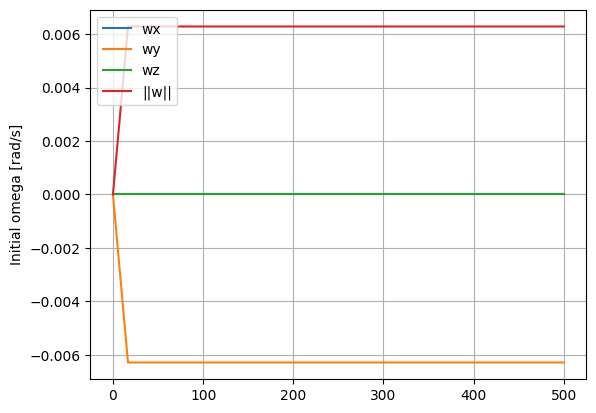

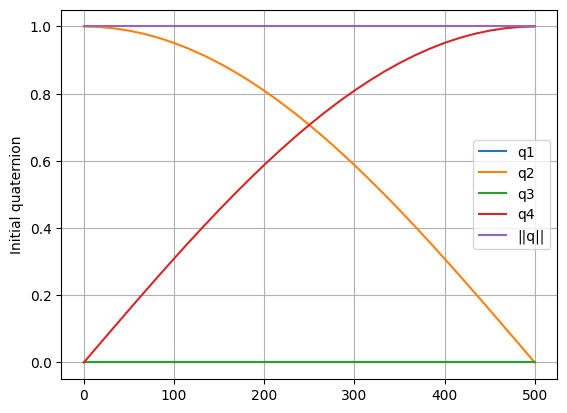

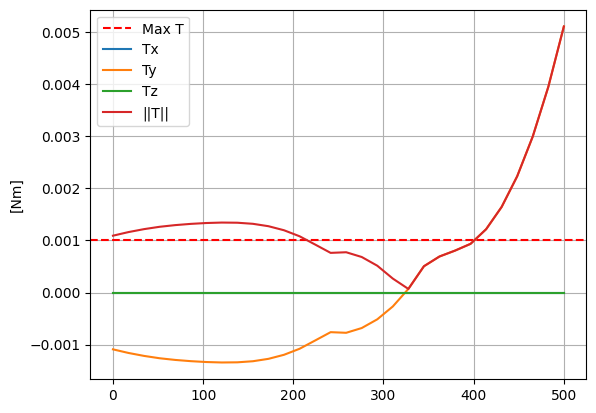

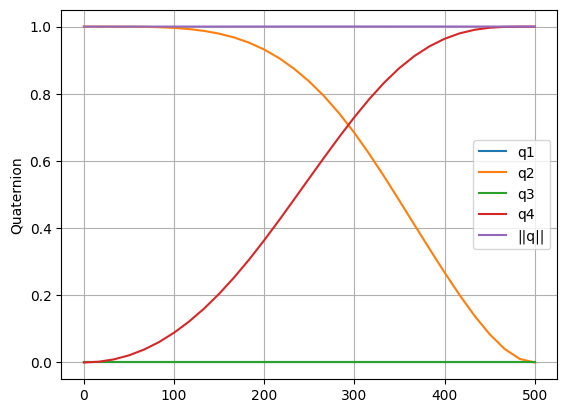

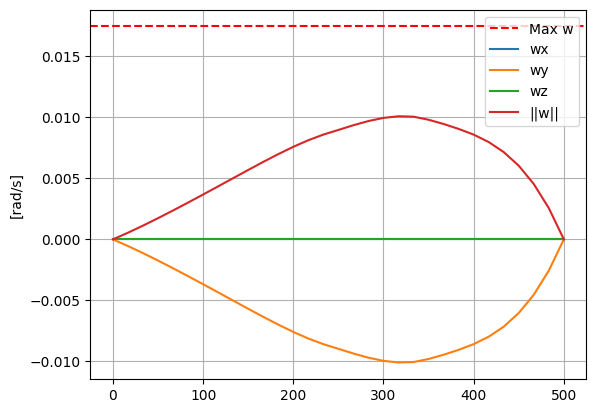

In [21]:
u_value=np.copy(u_global)
nx_value=np.copy(x_global)
u_value = scaling_begin(u_value,u_qw_scaling,T)
plt.figure(2)
plt.plot(np.linspace(0, tf, T+1), ox_angvel[0,:], label='wx')
plt.plot(np.linspace(0, tf, T+1), ox_angvel[1,:], label='wy')
plt.plot(np.linspace(0, tf, T+1), ox_angvel[2,:], label='wz')
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(ox_angvel,axis=0), label='||w||')
plt.ylabel('Initial omega [rad/s]')
plt.gca().tick_params(labelsize=10)
plt.legend()
plt.grid(True)

plt.figure(3)
plt.plot(np.linspace(0, tf, T+1), ox_quat[0,:], label='q1')
plt.plot(np.linspace(0, tf, T+1), ox_quat[1,:], label='q2')
plt.plot(np.linspace(0, tf, T+1), ox_quat[2,:], label='q3')
plt.plot(np.linspace(0, tf, T+1), ox_quat[3,:], label='q4')
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(ox_quat,axis=0), label='||q||')
plt.ylabel('Initial quaternion')
plt.gca().tick_params(labelsize=10)
plt.legend()
plt.grid(True)

plt.figure(5)
plt.axhline(y=u_max_torq_double, color='r', linestyle='--', label='Max T')
plt.plot(np.linspace(0, tf, T), u_value[0,:], label='Tx')
plt.plot(np.linspace(0, tf, T), u_value[1,:], label='Ty')
plt.plot(np.linspace(0, tf, T), u_value[2,:], label='Tz')
plt.plot(np.linspace(0, tf, T), np.linalg.norm(u_value[0:3,:],axis=0), label='||T||')
plt.ylabel('[Nm]')
plt.gca().tick_params(labelsize=10)
plt.legend()
plt.grid(True)

plt.figure(6)
plt.plot(np.linspace(0, tf, T+1), nx_value[0,:], label='q1')
plt.plot(np.linspace(0, tf, T+1), nx_value[1,:], label='q2')
plt.plot(np.linspace(0, tf, T+1), nx_value[2,:], label='q3')
plt.plot(np.linspace(0, tf, T+1), nx_value[3,:], label='q4')
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(nx_value[0:4,:],axis=0), label='||q||')
plt.ylabel('Quaternion')
plt.gca().tick_params(labelsize=10)
plt.legend()
plt.grid(True)

plt.figure(7)
plt.axhline(y=omega_max_double, color='r', linestyle='--', label='Max w')
plt.plot(np.linspace(0, tf, T+1), nx_value[4,:], label='wx')
plt.plot(np.linspace(0, tf, T+1), nx_value[5,:], label='wy')
plt.plot(np.linspace(0, tf, T+1), nx_value[6,:], label='wz')
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(nx_value[4:7,:],axis=0), label='||w||')
plt.ylabel('[rad/s]')
plt.gca().tick_params(labelsize=10)
plt.legend()
plt.grid(True)

In [10]:
print(np.linalg.norm(vc.value,2))

9.845325921910504e-05


In [17]:
import numpy as np
import plotly.graph_objs as go
from scipy.spatial.transform import Rotation as R

def create_cube(size, quaternion):
    """Creates a rotated cube using a quaternion."""
    half = size / 2.0
    vertices = np.array([  # Cube vertices
        [-half, -half, -half-size], [half, -half, -half-size], [half, half, -half-size], [-half, half, -half-size],
        [-half, -half, half+size], [half, -half, half+size], [half, half, half+size], [-half, half, half+size]
    ])
 
    # Apply rotation using quaternion
    r = R.from_quat(quaternion)
    rotated_vertices = r.apply(vertices)

    # Cube faces (each face as a set of 4 vertices)
    faces = [
        [0, 1, 2, 3], [4, 5, 6, 7], [0, 1, 5, 4],
        [2, 3, 7, 6], [0, 3, 7, 4], [1, 2, 6, 5]
    ]

    # Define mesh faces for the cube
    i_faces = [face[0] for face in faces]
    j_faces = [face[1] for face in faces]
    k_faces = [face[2] for face in faces]
    i_faces += [face[0] for face in faces]
    j_faces += [face[2] for face in faces]
    k_faces += [face[3] for face in faces]

    # Mesh3d for the cube (white cube)
    cube = go.Mesh3d(
        x=rotated_vertices[:, 0], y=rotated_vertices[:, 1], z=rotated_vertices[:, 2],
        i=i_faces, j=j_faces, k=k_faces, opacity=1.0, color='white'
    )

    # Create "eyes" (small blue circles) on the cube's faces
    eye_radius = 0.1*0.2
    eye_positions = [
        [half,0.13*0.2,0], [half,-0.13*0.2,0]
    ]

    # Apply rotation to eye positions
    rotated_eye_positions = r.apply(eye_positions)

    eye_spheres = []
    for pos in rotated_eye_positions:
        u, v = np.mgrid[0:2*np.pi:10j, 0:np.pi:5j]
        x_eye = eye_radius * np.cos(u) * np.sin(v) + pos[0]
        y_eye = eye_radius * np.sin(u) * np.sin(v) + pos[1]
        z_eye = eye_radius * np.cos(v) + pos[2]
        
        # Crear una matriz de color uniforme (por ejemplo, azul con un solo valor)
        color_value = np.full_like(x_eye, 0.5)  # 0.5 es un tono de azul en la escala

        eye_spheres.append(go.Surface(
            x=x_eye, y=y_eye, z=z_eye, surfacecolor=color_value, 
            colorscale=[[0, 'deepskyblue'], [1, 'deepskyblue']], opacity=1.0, showscale=False
        ))

    return cube, eye_spheres

def create_spheres(spheres):
    """Creates spheres as surfaces."""
    sphere_traces = []
    for sphere in spheres:
        h, rc = sphere['h'], sphere['rc']
        u, v = np.mgrid[0:2*np.pi:16j, 0:np.pi:8j]
        x_sphere = rc * np.cos(u) * np.sin(v) + h[0]
        y_sphere = rc * np.sin(u) * np.sin(v) + h[1]
        z_sphere = rc * np.cos(v) + h[2]
        sphere_traces.append(go.Surface(
            x=x_sphere, y=y_sphere, z=z_sphere, colorscale='Reds', opacity=0.3, showscale=False
        ))
    return sphere_traces

def plot_3d_trajectory_with_cube(nx_value):
    quaternions = nx_value[0:4, :]


    # Set axis limits with uniform scaling
    padding = 0.5

    # Initial cube (white with blue eyes)
    cube, eye_spheres = create_cube(0.1, quaternions[:, 0])

    # Animation frames
    print(quaternions.shape[1])
    frames = [
        go.Frame(data=[
            create_cube(0.1, quaternions[:, k])[0],
        ] + create_cube(0.1, quaternions[:, k])[1])
        for k in range(quaternions.shape[1])
    ]

    layout = go.Layout(
        title='BIRDS-TM guidance',
        scene=dict(
            xaxis=dict(title='x [m]', range=[-0.4, 0.4]),
            yaxis=dict(title='y', range=[-0.4, 0.4]),
            zaxis=dict(title='z', range=[-0.4, 0.4]),

            aspectmode='cube',  # Ensures correct proportions
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))  # Adjust camera view for better visibility
        ),
        updatemenus=[dict(type='buttons', buttons=[dict(label='Play', method='animate',
                                                       args=[None, dict(frame=dict(duration=50, redraw=True),
                                                                        fromcurrent=True)])])])

    fig = go.Figure(data=[cube] + eye_spheres, layout=layout, frames=frames)
    fig.show()

plot_3d_trajectory_with_cube(x_global)


31


In [18]:
import os
import shutil
import re

def collect_files(source_folder):
    # Define the destination folder
    destination_folder = os.path.join(source_folder, 'matlab_copy')
    
    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
    
    # Files to delete
    files_to_delete = ['runecos_exp.c', 'runecos.c','CMakeCCompilerId.c']
    
    # Files in which to replace 'pinv' with 'pinv2'
    files_to_replace = ['splamm.h', 'splamm.c', 'preproc.c']
    
    # Files to modify by removing "../../include/"
    files_to_modify = ['ldl.h', 'ldl.c']

    # Walk through the source folder and its subfolders
    for root, dirs, files in os.walk(source_folder):
        # Skip the destination folder
        if root == destination_folder:
            continue
        
        for file in files:
            file_path = os.path.join(root, file)
            
            if file.endswith('.c') or file.endswith('.h'):
                # Copy the file to the destination folder
                shutil.copy(file_path, destination_folder)
                print(f"Copied {file_path} to {destination_folder}")

    # After all files are copied, process the files in the destination folder
    for file in os.listdir(destination_folder):
        file_path = os.path.join(destination_folder, file)
        
        # Delete the specified files
        if file in files_to_delete:
            os.remove(file_path)
            print(f"Deleted {file_path}")
            continue
        
        # Modify ldl.h and ldl.c files to remove "../../include/"
        if file in files_to_modify:
            with open(file_path, 'r') as f:
                content = f.read()
            content = content.replace('../../include/', '')
            with open(file_path, 'w') as f:
                f.write(content)
            print(f"Modified {file} to remove '../../include/'")
        
        # Replace 'pinv' function calls with 'pinv2' in specified files
        if file in files_to_replace:
            with open(file_path, 'r') as f:
                content = f.read()
            content = re.sub(r'\bpinv\b\s*\(', 'pinv2(', content)
            with open(file_path, 'w') as f:
                f.write(content)
            print(f"Replaced 'pinv' function calls with 'pinv2' in {file}")

# Usage example
source_folder = 'CUBESAT_SCVX_ECOS_T31'
collect_files(source_folder)

Copied CUBESAT_SCVX_ECOS_T31\c\build\CMakeFiles\4.1.2\CompilerIdC\CMakeCCompilerId.c to CUBESAT_SCVX_ECOS_T31\matlab_copy
Copied CUBESAT_SCVX_ECOS_T31\c\include\cpg_solve.h to CUBESAT_SCVX_ECOS_T31\matlab_copy
Copied CUBESAT_SCVX_ECOS_T31\c\include\cpg_workspace.h to CUBESAT_SCVX_ECOS_T31\matlab_copy
Copied CUBESAT_SCVX_ECOS_T31\c\solver_code\ecos_bb\ecos_bb.c to CUBESAT_SCVX_ECOS_T31\matlab_copy
Copied CUBESAT_SCVX_ECOS_T31\c\solver_code\ecos_bb\ecos_bb_preproc.c to CUBESAT_SCVX_ECOS_T31\matlab_copy
Copied CUBESAT_SCVX_ECOS_T31\c\solver_code\external\amd\include\amd.h to CUBESAT_SCVX_ECOS_T31\matlab_copy
Copied CUBESAT_SCVX_ECOS_T31\c\solver_code\external\amd\include\amd_internal.h to CUBESAT_SCVX_ECOS_T31\matlab_copy
Copied CUBESAT_SCVX_ECOS_T31\c\solver_code\external\amd\src\amd_1.c to CUBESAT_SCVX_ECOS_T31\matlab_copy
Copied CUBESAT_SCVX_ECOS_T31\c\solver_code\external\amd\src\amd_2.c to CUBESAT_SCVX_ECOS_T31\matlab_copy
Copied CUBESAT_SCVX_ECOS_T31\c\solver_code\external\amd\src\a